# A comparison between two TTI implementations: Devito and Madagascar

This tutorial attempts to draw a comparison between the low rank finite-difference (FD) from [Song et al., 2013](https://academic.oup.com/gji/article/193/2/960/634855), which can be reproduced via [Madagascar](http://www.ahay.org/wiki/Main_Page) and an approach proposed by [Zhang et al., 2011](https://library.seg.org/doi/10.1190/1.3554411) implemented throught an explicit FD scheme with [Devito](https://www.devitoproject.org/).

I have grouped all imports used in this notebook here for consistency.

In [1]:
# basic imports.  
import os
import sys
#sys.path.append('/opt/madagascar/3.0/lib/python2.7/site-packages')

for path in sys.path:
    print(path)

/home/oscarm/lfd/bptti

/opt/madagascar/3.0/lib/python2.7/site-packages
/opt/anaconda3/envs/devito
/opt/anaconda3/envs/devito/lib/python38.zip
/opt/anaconda3/envs/devito/lib/python3.8
/opt/anaconda3/envs/devito/lib/python3.8/lib-dynload
/home/oscarm/.local/lib/python3.8/site-packages
/home/oscarm/devito
/opt/anaconda3/envs/devito/lib/python3.8/site-packages
/opt/anaconda3/envs/devito/lib/python3.8/site-packages/IPython/extensions
/home/oscarm/.ipython


In [2]:
from devito import *
from examples.seismic import SeismicModel, plot_velocity, plot_image, setup_geometry
from examples.seismic import RickerSource, TimeAxis, Receiver
from examples.seismic.tti import AnisotropicWaveSolver
from examples.seismic.tti.operators import kernel_centered_2d

/opt/anaconda3/envs/devito/lib/python3.8/site-packages/mpmath/ctx_mp_python.py:892: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/opt/anaconda3/envs/devito/lib/python3.8/site-packages/mpmath/ctx_mp_python.py:986: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:


In [3]:
import numpy as np
import matplotlib
# use the nbagg backend to render plot.  It provides basic zoom and pan capability.
#matplotlib.use('nbagg') # previously I used this magic command: %matplotlib inline
# I think import matplotlib.pyplot must be after matplotlib.use('nbagg') 
import matplotlib.pyplot as plt

#m8r library provides read and write of madagascar data
import m8r 

In [4]:
cwd = os.getcwd()        # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
#print("Files in %r: %s" % (cwd, files))

## Madagascar

### Song, Xiaolei, Sergey Fomel, and Lexing Ying. "Lowrank finite-differences and lowrank Fourier finite-differences for seismic wave extrapolation in the acoustic approximation." Geophysical Journal International 193.2 (2013): 960-969.

The following cells simply execute some commands from the Python script (SConstruct) located in /lfd/bptti. It's assumed that the BP 2007 sgy files have been downloaded and are located in the *ModelParams* folder

In [5]:
pars = ['epsilon', 'delta', 'theta', 'vp']

sgy = {}
for par in pars:
    sgy[par] = os.path.join('ModelParams',par.capitalize() + '_Model.sgy')

Read the sgy files:

In [6]:
for par in pars:
    TARGETS = [par+'.asc',par+'.bin']
    if par == 'vp':
        os.system('''sfsegyread < {} hfile={} bfile={} read=d | 
                  sfput o2=0 d2=0.00625 label2=Distance unit2=km o1=0 d1=0.00625 label1=Depth unit1=km | 
                  sfscale dscale=0.001 > {}'''.format(sgy[par], TARGETS[0], TARGETS[1], par+'.rsf'))
    else:
        os.system('''sfsegyread < {} hfile={} bfile={} read=d | 
                  sfput o2=0 d2=0.00625 label2=Distance unit2=km o1=0 d1=0.00625 label1=Depth unit1=km > {}'''.format(sgy[par], TARGETS[0], TARGETS[1], par+'.rsf'))

Load the velocity rsf file into numpy array and plot it using matplotlib:

(12596, 1801)


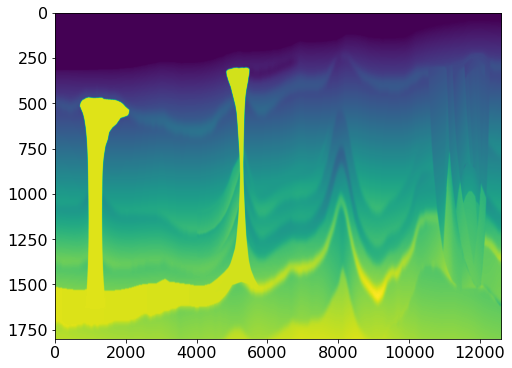

In [7]:
inp=m8r.Input("vp.rsf")
alltraces=inp.read()
inp.close()
print(alltraces.shape)
plt.imshow(alltraces.T,aspect='auto')
plt.show()

Carry out some mathematical operations on rsf files to get *vx* and *yita*:

In [8]:
SOURCES = ['vp.rsf', 'epsilon.rsf']
os.system('''sfmath < {} e={} output="input*sqrt(1+2*e)" > {}'''.format(SOURCES[0], SOURCES[1], 'vx.rsf'))
SOURCES = ['epsilon.rsf', 'delta.rsf']
os.system('''sfmath e={} d={} output="(e-d)/(1+2*d)" > {}'''.format(SOURCES[0], SOURCES[1], 'yita.rsf'))

0

Crate the source wavelet:

In [9]:
nt=2001
dt=0.001
os.system('''sfspike n1=%d d1=%g k1=101 | sfricker1 frequency=15 > %s''' % (nt, dt, 'source.rsf'))

0

Load the source rsf file into numpy array and plot it using matplotlib:

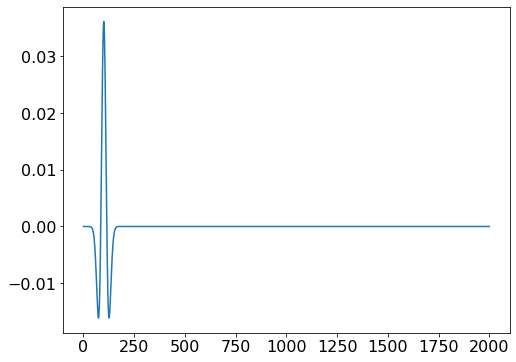

In [10]:
inp=m8r.Input("source.rsf")
source=inp.read()
inp.close()
plt.plot(source) # Plot source
plt.show()

Crop the velocity and anisotropic parameters to do faster computations:

In [11]:
for par in ('vp','vx','yita','theta'):
    os.system('sfwindow < {} j1=2 j2=2 | sfwindow  n2=2048 f2=2759 n1=900 > {}'.format(par+'.rsf', par+'end2.rsf'))
    
for par in ('vp','vx','yita','theta'):
    os.system('sfwindow < {} n2=1024 f2=512 > {}'.format(par+'end2.rsf', par+'0.rsf'))

In [12]:
os.system('sflfdanc2_25 < {} velx={} eta={} seta={} dt=0.001 eps=0.000001 npk=30 DE=1 size=17 s1={} s2={} > {}'.format('vp0.rsf','vx0.rsf','yita0.rsf','theta0.rsf','s1_lfdc.rsf','s2_lfdc.rsf','G_25_lfdc.rsf'))

0

Run the optimized FD wave extrapolation, it can take some minutes:

In [13]:
os.system('sfofd2_25 < {} vel={} G={} isx=512 isz=2 s1={} s2={} dt={:f} nt={:d} > {}'.format('source.rsf','vp0.rsf','G_25_lfdc.rsf','s1_lfdc.rsf','s2_lfdc.rsf',dt,nt,'wavan_lfdc.rsf'))

0

A file of ~ 7GB with the snapshots is created after the execution above. The *sfwindow* command is used to get the the snaps at time steps 1500 and 2000

In [17]:
os.system('sfwindow < {} n3=1 f3=1500 > {}'.format('wavan_lfdc.rsf', 'lfd_snap1.rsf'))
os.system('sfwindow < {} n3=1 f3=2000 > {}'.format('wavan_lfdc.rsf', 'lfd_snap2.rsf'))

0

Load the lfd_snap1.rsf file into numpy array and plot it using matplotlib:

921600 (1024, 900)


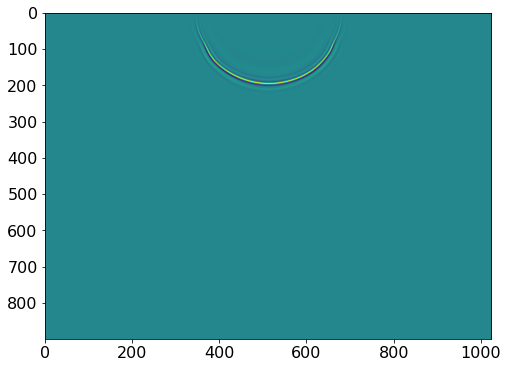

In [18]:
inp=m8r.Input("lfd_snap1.rsf")
wavan1=inp.read()
print(wavan1.size,wavan1.shape)
inp.close()
inp=m8r.Input("lfd_snap2.rsf")
wavan2=inp.read()
inp.close()

plt.imshow(wavan1.T,aspect='auto')
plt.show()

## Devito
### Zhang, Yu, Houzhu Zhang, and Guanquan Zhang. "A stable TTI reverse time migration and its implementation." Geophysics 76.3 (2011): WA3-WA11.

Crop the missing anisotropic parameters (required for Devito implementation) with the same dimensions used before:

In [19]:
for par in ('epsilon', 'delta'):
    os.system('sfwindow < {} j1=2 j2=2 | sfwindow  n2=2048 f2=2759 n1=900 > {}'.format(par+'.rsf', par+'end2.rsf'))
    
for par in ('epsilon', 'delta'):
    os.system('sfwindow < {} n2=1024 f2=512 > {}'.format(par+'end2.rsf', par+'0.rsf'))

Read the velocity and anisotropic parameters:

In [20]:
# Read vp
inp=m8r.Input("vp0.rsf")
shape = (inp.int("n2"), inp.int("n1"))
origin = (inp.float("o2"), inp.float("o1"))
spacing = (1e3*inp.float("d2"), 1e3*inp.float("d1"))
vp = inp.read()
inp.close()

epsilon = np.empty(shape)
delta = np.empty(shape)
theta = np.empty(shape)

params = [epsilon, delta, theta]

# Read Thomsem parameters
for file, par in zip(pars, params):
    inp= m8r.Input(file+'0.rsf')
    par[:] = inp.read()
    inp.close()
    
theta *= (np.pi/180.)  # use radians

print(origin, shape, spacing)

(40.8875, 0.0) (1024, 900) (12.5, 12.5)


Plot parameters:

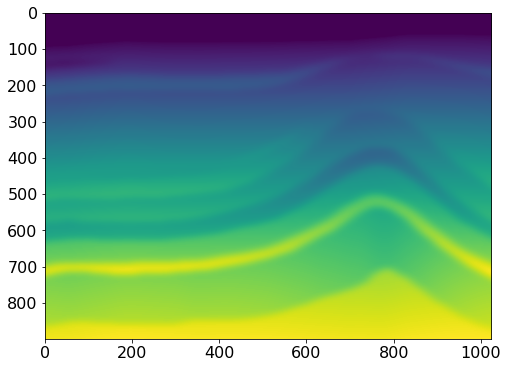

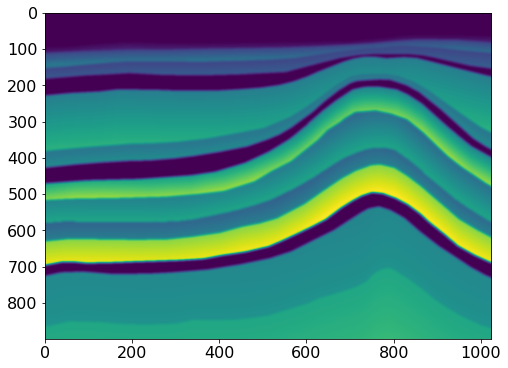

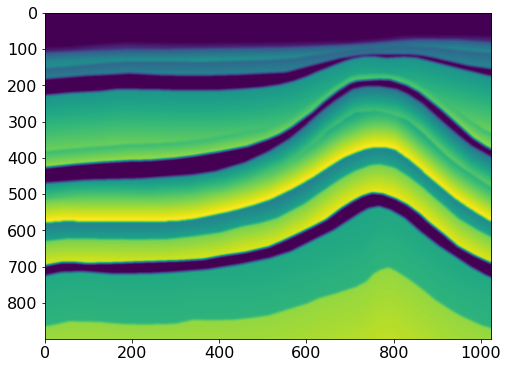

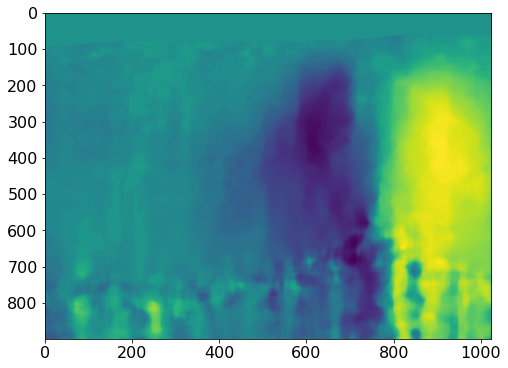

In [21]:
plt.imshow(vp.T,aspect='auto')
plt.show()
plt.imshow(epsilon.T,aspect='auto')
plt.show()
plt.imshow(delta.T,aspect='auto')
plt.show()
plt.imshow(theta.T,aspect='auto')
plt.show()

Some parameter definitions:

In [22]:
space_order=8  # FD-order to approx. spatial derivatives
nbl=0          # No border

model= SeismicModel(vp=vp, origin=origin, shape=shape, spacing=spacing,
                 space_order=space_order, nbl=nbl, epsilon=epsilon,
                 delta=delta, theta=theta, phi=None, bcs="damp", dtype=np.float32)

t0 = 0.        # Simulation starts a t=0
tn = 2000.     # Simulation last 2 second (2000 ms)
dt_devito = 1  # Time step used by Madagascar (1 ms)
print(model.critical_dt) # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt_devito)
print(time_range)

Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


1.229
TimeAxis: start=0, stop=2000, step=1, num=2001


Create source wavelet w peak frequency of 15 Hz as in the Madagascar simulation

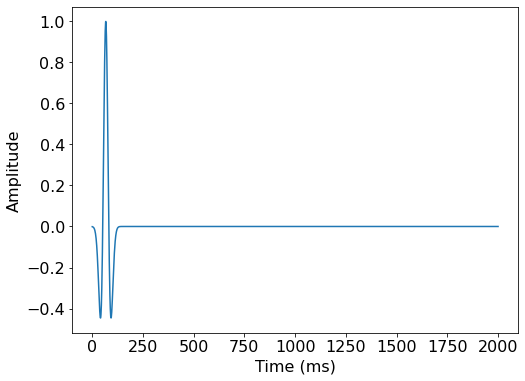

In [23]:
f0 = 0.015
src = RickerSource(name='src', grid=model.grid, time_range=time_range,
                         f0=f0, npoint=1)

src.show()

Plot sources obtained from *Madagascar command - sfricker1* and *Devito function - RickerSource*

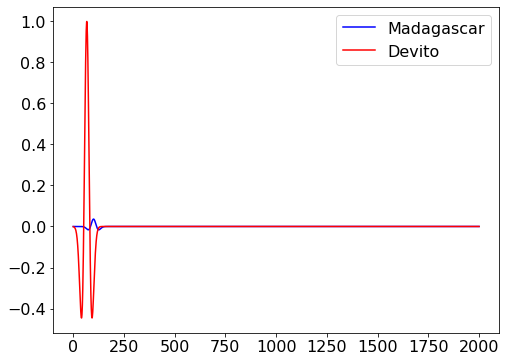

In [24]:
l1, = plt.plot(source, 'blue')
l2, = plt.plot(src.data.flatten(), 'red')
plt.legend(['Madagascar', 'Devito'])
plt.show()

Define geometry. Note the source position is the same as that used in Madagascar simulation

In [25]:
isx=512 
isz=2
# Source and receiver geometries
src_coordinates = np.empty((1, model.dim))
src_coordinates[0, :] =  model.origin[0] + isx*model.spacing[0]
src_coordinates[0, -1] = model.origin[-1] + isz*model.spacing[-1]

nrecx = model.shape[0]
recx = np.linspace(model.origin[0], model.domain_size[0], nrecx)


rec_coordinates = np.empty((nrecx, model.dim))
rec_coordinates[:, 0] = recx
rec_coordinates[:, -1] = model.origin[-1] + 2 * model.spacing[-1]
print(src_coordinates)

rec = Receiver(name='rec', grid=model.grid, time_range=time_range,
               npoint=nrecx)

rec.coordinates.data[:]=rec_coordinates[:]
src.coordinates.data[:]=src_coordinates[:]

[[6440.88750076   25.        ]]


Copy source obtained with Madagascar into *src* array as source wavelets are different

In [26]:
src.data[:]=source.reshape(-1, 1)

Plot source wavelets again to check they match:

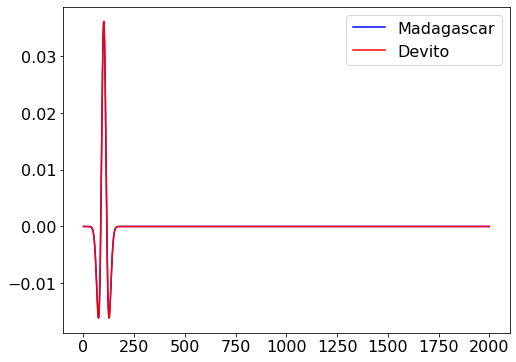

In [27]:
l1, = plt.plot(source, 'blue')
l2, = plt.plot(src.data.flatten(), 'red')
plt.legend(['Madagascar', 'Devito'])
plt.show()

Create Devito Operator. All time steps are saved for comparison: 

In [28]:
kernel = 'centered'
dt = model.grid.time_dim.spacing
m = model.m
time_order = 1 if kernel == 'staggered' else 2
if kernel == 'staggered':
    stagg_u = stagg_v = NODE
else:
    stagg_u = stagg_v = None

# Create symbols for forward wavefield, source and receivers
uu = TimeFunction(name='uu', grid=model.grid, staggered=stagg_u,
                 save=time_range.num,
                 time_order=time_order, space_order=space_order)
vv = TimeFunction(name='vv', grid=model.grid, staggered=stagg_v,
                 save=time_range.num,
                 time_order=time_order, space_order=space_order)

# FD kernels of the PDE
stencils = kernel_centered_2d(model, uu, vv, space_order)

# Source and receivers
stencils += src.inject(field=uu.forward, expr=src * dt**2 / m)
stencils += src.inject(field=vv.forward, expr=src * dt**2 / m)
stencils += rec.interpolate(expr=uu + vv)
op_tti= Operator(stencils, subs=model.spacing_map, name='ForwardTTI')

Run the simulation with Devito Operator:

In [29]:
op_tti(dt=dt_devito)

Operator `ForwardTTI` run in 47.32 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.009911999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=47.08141200000007, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0017289999999999589, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.22157799999999933, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Plot snaps at time step 1500  

(2001, 1024, 900)


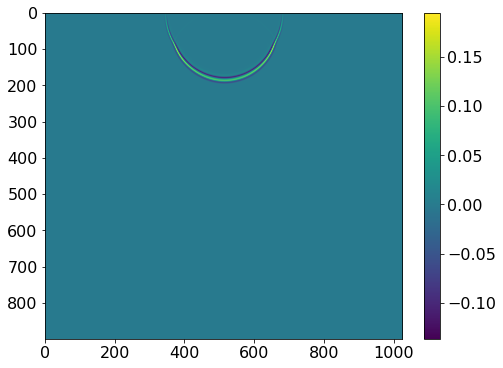

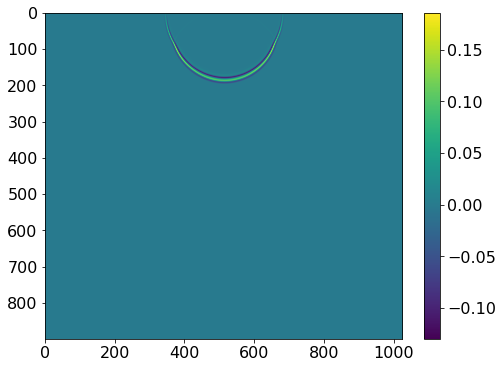

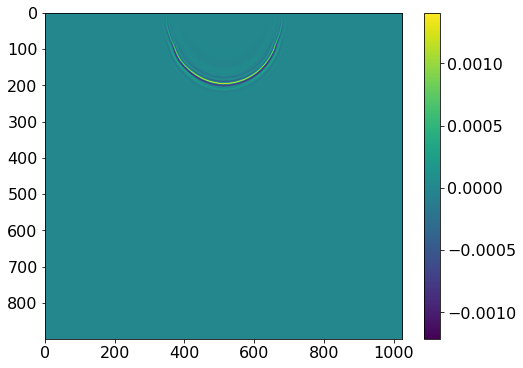

In [37]:
print(uu.shape)
snap1_udevito=uu.data[1500]
snap1_vdevito=vv.data[1500]

plt.imshow(uu.data[1500].T,aspect='auto')
colorbar = plt.colorbar()
plt.show()
plt.imshow(vv.data[1500].T,aspect='auto')
colorbar = plt.colorbar()
plt.show()
plt.imshow(wavan1.T,aspect='auto')
colorbar = plt.colorbar()
plt.show()

Plot profiles at *x=512* (center of domain)

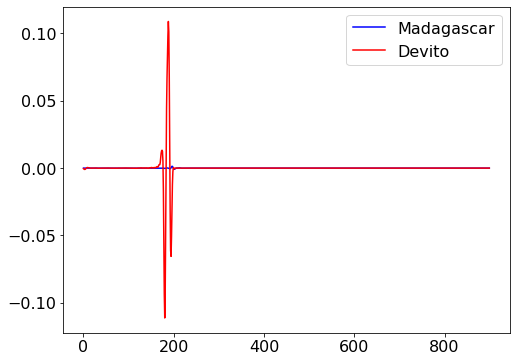

In [38]:
l1, = plt.plot(wavan1[512], 'blue')
l2, = plt.plot(snap1_udevito[512], 'red')
plt.legend(['Madagascar', 'Devito'])
plt.show()

Plot only profile obtained with Madagascar:

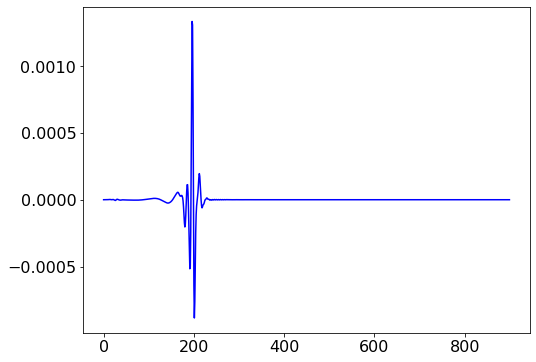

In [39]:
plt.plot(wavan1[512], 'blue')
plt.show()

Plot snaps at time step 2000:

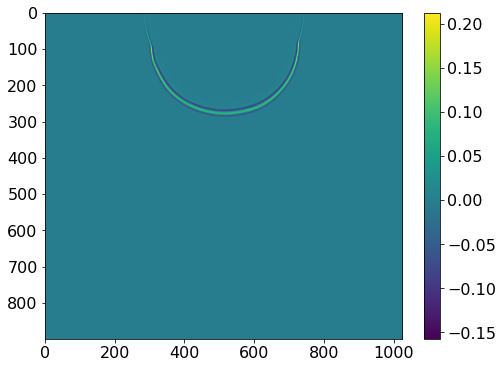

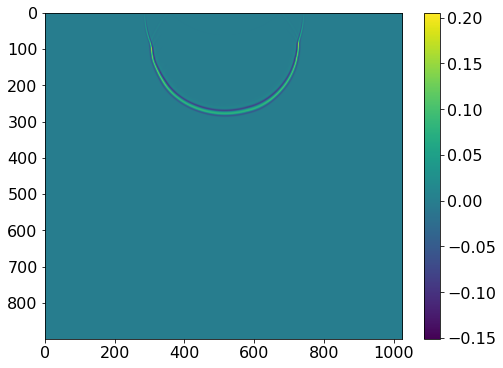

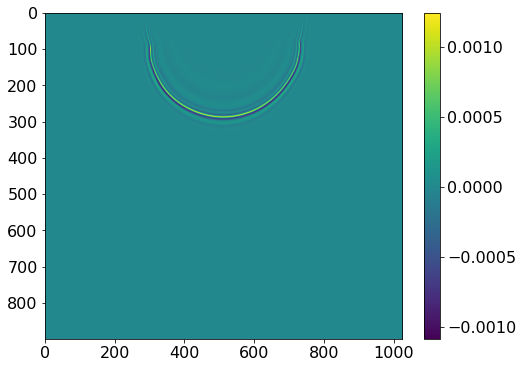

In [40]:
snap2_udevito=uu.data[2000]
snap2_vdevito=vv.data[2000]

plt.imshow(uu.data[2000].T,aspect='auto')
colorbar = plt.colorbar()
plt.show()
plt.imshow(vv.data[2000].T,aspect='auto')
colorbar = plt.colorbar()
plt.show()
plt.imshow(wavan2.T,aspect='auto')
colorbar = plt.colorbar()
plt.show()

Plot profiles at *x=512* (center of domain)

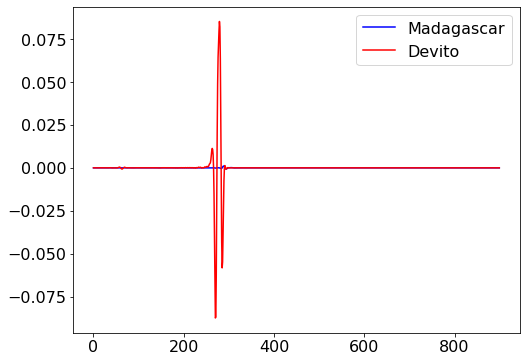

In [41]:
l1, = plt.plot(wavan2[512], 'blue')
l2, = plt.plot(snap2_udevito[512], 'red')
plt.legend(['Madagascar', 'Devito'])
plt.show()

Plot only profile obtained with Madagascar:

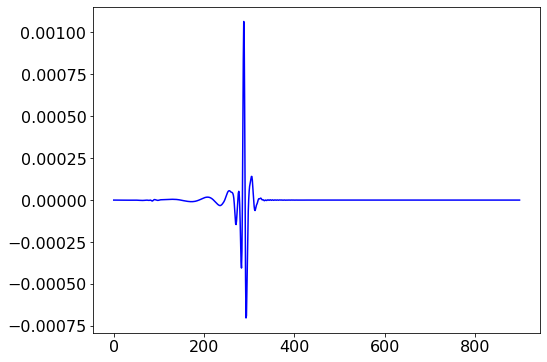

In [42]:
plt.plot(wavan2[512], 'blue')
plt.show()

Plot profile of sum of fields *u* and *v* at *x=512* and time step 2000

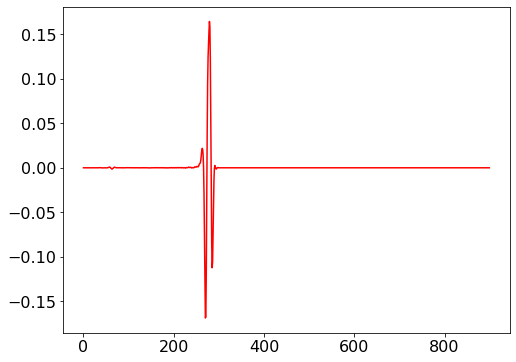

In [43]:
plt.plot(snap2_udevito[512]+snap2_vdevito[512], 'red')
plt.show()

**The waveforms are different!**